# 1.   Загрузка, предобработка

In [297]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

Загружаем исходные данные

In [298]:
# грузим оригинальный train.csv
try:
    train_orig = pd.read_csv('train.csv')
except FileNotFoundError:
    print('Файл train.csv отсутствует')
except Exception as e:
    print(f'Возникла ошибка {e.args[1]}')

In [299]:
# грузим оригинальный objects.csv (который building_meta в задании)
try:
    building_meta_orig = pd.read_csv('objects.csv')
except FileNotFoundError:
    print('Файл objects.csv отсутствует')
except Exception as e:
    print(f'Возникла ошибка {e.args[1]}')

In [300]:
building_meta_orig.sample(4)

,Unnamed: 0,city,obj_id,function,square,year,floor
1251,1251,14,1251,Education,104604,NaN,NaN
1185,1185,13,1185,Office,129532,NaN,NaN
1039,1039,12,1039,Education,30171,NaN,3.0
184,184,2,184,Education,34171,NaN,NaN


In [301]:
# грузим оригинальный weather_train/test.csv
try:
    weather_train_orig = pd.read_csv('wtrain.csv')
except FileNotFoundError:
    print('Файл wtrain.csv отсутствует')
except Exception as e:
    print(f'Возникла ошибка {e.args[1]}')

In [302]:
# грузим оригинальный weather_train/test.csv
try:
    weather_test_orig = pd.read_csv('wtest.csv')
except FileNotFoundError:
    print('Файл wtest.csv отсутствует')
except Exception as e:
    print(f'Возникла ошибка {e.args[1]}')

In [319]:
# грузим test.csv
try:
    test_orig = pd.read_csv('test.csv')
except FileNotFoundError:
    print('Файл test.csv отсутствует')
except Exception as e:
    print(f'Возникла ошибка {e.args[1]}')

Возникла ошибка int64


Посмотрим исходные типы данных и сводную информацию по загруженным датасетам

In [304]:
# для train.csv
train_orig.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 5 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Unnamed: 0  int64  
 1   obj_id      int64  
 2   counter     int64  
 3   datetime    object 
 4   value       float64
dtypes: float64(1), int64(3), object(1)
memory usage: 2.0 GB


Что-то не так с датой (не распарсена), потенциально лишний признак, избыточные размеры. Сейчас датасет занимает 2GB в ОЗУ. Пропущенных значений не наблюдается

Проверим какие признаки можно "сжать"

In [305]:
# сводная информация по obj_id
train_orig.obj_id.describe()

count    2.021610e+07
mean     7.992780e+02
std      4.269133e+02
min      0.000000e+00
25%      3.930000e+02
50%      8.950000e+02
75%      1.179000e+03
max      1.448000e+03
Name: obj_id, dtype: float64

Видим, что тип **obj_id** можно сократить до ushort.

In [306]:
# сводная информация по counter
train_orig.counter.describe()

count    2.021610e+07
mean     6.624412e-01
std      9.309921e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      3.000000e+00
Name: counter, dtype: float64

Признак **counter** можно сжать до uint8

**datetime** с неверным типом. Исправим это

In [307]:
train_orig.datetime = pd.to_datetime(train_orig.datetime)

In [308]:
# сводная информация по value
train_orig.value.describe()

count    2.021610e+07
mean     2.117121e+03
std      1.532356e+05
min      0.000000e+00
25%      1.830000e+01
50%      7.877500e+01
75%      2.679840e+02
max      2.190470e+07
Name: value, dtype: float64

**value** пока оставляем в покое

Очевидно, что от Unnamed можно избавиться или вынести в индекс. Проверим

In [309]:
(train_orig['Unnamed: 0'] == train_orig.index).any()

True

In [310]:
# удалим столбец **Unnamed: 0**
train_orig = train_orig.drop('Unnamed: 0', axis=1)

Сжимаем obj_id и counter

In [311]:
train_orig.obj_id = train_orig.obj_id.astype(np.ushort)

In [312]:
train_orig.counter = train_orig.counter.astype(np.uint8)

Проверим что получилось

In [313]:
train_orig.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
 #   Column    Dtype         
---  ------    -----         
 0   obj_id    uint16        
 1   counter   uint8         
 2   datetime  datetime64[ns]
 3   value     float64       
dtypes: datetime64[ns](1), float64(1), uint16(1), uint8(1)
memory usage: 366.3 MB


**Вывод по train**

Удалось привести типы признаков к верным и минимальным по размерам, удалён лишний признак. Таки образом удалось сжать датасет до 366.3 MB

In [314]:
# процент оптимизации
print('train сжат на {}%'.format(round((1 - 366.3/2048) * 100), 2))

train сжат на 82%


Посмотрим сводную информацию по test и возможно напишем волшебную функцию для повторения действий выше

In [320]:
test_orig.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41697600 entries, 0 to 41697599
Data columns (total 3 columns):
 #   Column    Dtype         
---  ------    -----         
 0   obj_id    uint16        
 1   counter   uint8         
 2   datetime  datetime64[ns]
dtypes: datetime64[ns](1), uint16(1), uint8(1)
memory usage: 437.4 MB


Занимаемый объём в 4.2 Гб. Пропусков нет. Интересно, здесь ещё есть Unnamed: 0.1. Кто ты?

In [321]:
# test_orig['Unnamed: 0.1'].sample(4)

Проверим его равенство с индексом, если так, то и его удалить без зазрений совести

In [322]:
# (test_orig['Unnamed: 0.1'] == test_orig.index).any()

Да, ничего в нём нового. Удалим

Готовим функцию по обработке train/test

In [326]:
def prepare_train_test(dataset):
    # исправляем тип datetime
    dataset.datetime = pd.to_datetime(dataset.datetime)
    # удалим столбец **Unnamed: 0**
    if 'Unnamed: 0' in dataset.columns:
        dataset = dataset.drop('Unnamed: 0', axis=1)
    # удалим столбец **Unnamed: 0.1**, если он есть
    if 'Unnamed: 0.1' in dataset.columns:
        dataset = dataset.drop('Unnamed: 0.1', axis=1)
    # Сжимаем obj_id и counter
    dataset.obj_id = dataset.obj_id.astype(np.ushort)
    dataset.counter = dataset.counter.astype(np.uint8)
    
    return dataset

Применим функцию на test_orig и посмотрим выхлоп

In [327]:
test_orig = prepare_train_test(test_orig)

In [328]:
test_orig.sample(4)

,obj_id,counter,datetime
2779359,1371,0,2017-12-14 09:00:00
40733715,211,0,2017-04-09 04:00:00
2074466,947,0,2018-07-17 02:00:00
9725888,1322,3,2018-07-05 20:00:00


In [329]:
test_orig.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41697600 entries, 0 to 41697599
Data columns (total 3 columns):
 #   Column    Dtype         
---  ------    -----         
 0   obj_id    uint16        
 1   counter   uint8         
 2   datetime  datetime64[ns]
dtypes: datetime64[ns](1), uint16(1), uint8(1)
memory usage: 437.4 MB


**Вывод по test**

Благодаря магической функции удалось привести типы признаков к верным и минимальным по размерам, удалены лишние признаки. Таким образом удалось сжать датасет до 437.4 MB

In [330]:
# процент оптимизации
print('test сжат на {}%'.format(round((1 - 437.4/(4.2 * 1024)) * 100), 2))

test сжат на 90%


Приступаем к анализу bulding_meta

In [331]:
# сводная информация
building_meta_orig.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  1449 non-null   int64  
 1   city        1449 non-null   int64  
 2   obj_id      1449 non-null   int64  
 3   function    1449 non-null   object 
 4   square      1449 non-null   int64  
 5   year        675 non-null    float64
 6   floor       355 non-null    float64
dtypes: float64(2), int64(4), object(1)
memory usage: 166.8 KB


Занимаемый объём 166.8 KB. Потенциально бесполезный Unnamed: 0.

**!**В year и floor наблюдаются пропуски

Посмотрим сводную по всем столбцам

In [332]:
building_meta_orig.describe()

,Unnamed: 0,city,obj_id,square,year,floor
count,1449.000000,1449.000000,1449.000000,1449.000000,675.000000,355.000000
mean,724.000000,6.952381,724.000000,92111.776398,1967.957037,3.740845
std,418.434583,5.003432,418.434583,110769.950997,31.054030,3.333683
min,0.000000,0.000000,0.000000,283.000000,1900.000000,1.000000
25%,362.000000,3.000000,362.000000,23012.000000,1949.000000,1.000000
50%,724.000000,5.000000,724.000000,57673.000000,1970.000000,3.000000
75%,1086.000000,13.000000,1086.000000,115676.000000,1995.000000,5.000000
max,1448.000000,15.000000,1448.000000,875000.000000,2017.000000,26.000000


**Вывод**

Можно сжать:

**city** и **floor** до uint8

**obj_id** и **year** до ushort

In [333]:
# сжимаем city
building_meta_orig.city = building_meta_orig.city.astype(np.uint8)

In [334]:
# сжимаем obj_id
building_meta_orig.obj_id = building_meta_orig.obj_id.astype(np.ushort)

Работаем с пропусками в **year** (год постройки)

In [335]:
# посмотрим количество пропущенных значений
building_meta_orig.year.isna().value_counts()

True     774
False    675
Name: year, dtype: int64

Пропусков достаточно много, больше 50%. Удалять признак опрометчиво, но и занять его медианой или средним неразумно. Заменю пропуски 0, как 'Unknown'

In [336]:

building_meta_orig.year.describe()

count     675.000000
mean     1967.957037
std        31.054030
min      1900.000000
25%      1949.000000
50%      1970.000000
75%      1995.000000
max      2017.000000
Name: year, dtype: float64

In [337]:
building_meta_orig.year = building_meta_orig.year.fillna(0)

In [338]:
# проверим пропуски
building_meta_orig.year.isna().value_counts()

False    1449
Name: year, dtype: int64

Пропусков в **year** нет, можно сжать до ushort

In [339]:
# сжимаем year
building_meta_orig.year = building_meta_orig.year.astype(np.ushort)

Работаем с пропусками в **floor** (количество этажей)

In [340]:
building_meta_orig.floor.isna().value_counts()

True     1094
False     355
Name: floor, dtype: int64

In [341]:
print(f'Пропущено {round(1094 / 1449 * 100, 2)} % значений в признаке floor!')

Пропущено 75.5 % значений в признаке floor!


Поскольку пропусков слишком много (можно считать, что практически все пустые), то со слезами на глазах просто его удаляем

In [342]:
building_meta_orig = building_meta_orig.drop('floor', axis=1)

Напоследок посмотрим не повторяет ли **Unnamed: 0** индекс

In [343]:
(building_meta_orig['Unnamed: 0'] == building_meta_orig.index).any()

True

Повторяет, а потому без слёз его удаляем

In [344]:
building_meta_orig = building_meta_orig.drop('Unnamed: 0', axis=1)

Остался признак назначения здания. Пропусков нет, но **что внутри**??

In [345]:
building_meta_orig.function.sample(4)

260                        Education
227    Entertainment/public assembly
479                  Public services
675         Manufacturing/industrial
Name: function, dtype: object

In [346]:
# какие значения принимает?
building_meta_orig.function.unique()

array(['Education', 'Lodging/residential', 'Office',
       'Entertainment/public assembly', 'Other', 'Retail', 'Parking',
       'Public services', 'Warehouse/storage', 'Food sales and service',
       'Religious worship', 'Healthcare', 'Utility', 'Technology/science',
       'Manufacturing/industrial', 'Services'], dtype=object)

Всего 16 значений. Уже сейчас можем:

    1. закодировать этот признак
    2. сменить тип на uint8
    
**Когда-то в будущем избавиться от категориальности**. Сейчас же нужен мЕньший объём? Let's do it!

Соберём словарь подмены значений

In [347]:
function_values = building_meta_orig.function.unique()

In [348]:
# сюда соберем что на что менять
function_values_dict = {}

In [349]:
for i in range(len(function_values)):
    function_values_dict[function_values[i]] = i

In [350]:
# проверяем наш чудо-словарь
function_values_dict

{'Education': 0,
 'Lodging/residential': 1,
 'Office': 2,
 'Entertainment/public assembly': 3,
 'Other': 4,
 'Retail': 5,
 'Parking': 6,
 'Public services': 7,
 'Warehouse/storage': 8,
 'Food sales and service': 9,
 'Religious worship': 10,
 'Healthcare': 11,
 'Utility': 12,
 'Technology/science': 13,
 'Manufacturing/industrial': 14,
 'Services': 15}

Когда-то он нам ещё пригодится. Сейчас просто подменим

In [351]:
building_meta_orig.function = building_meta_orig.function.replace(function_values_dict)

Осталось "сжать" **function**

In [352]:
building_meta_orig.function = building_meta_orig.function.astype(np.uint8)

Проверим что получилось в ходе предварительного сжатия building_meta

In [353]:
building_meta_orig.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   city      1449 non-null   uint8 
 1   obj_id    1449 non-null   uint16
 2   function  1449 non-null   uint8 
 3   square    1449 non-null   int64 
 4   year      1449 non-null   uint16
dtypes: int64(1), uint16(2), uint8(2)
memory usage: 19.9 KB


**Вывод по building_meta_orig**

Удалось привести типы признаков к верным и минимальным по размерам, удалены два лишних признака. Таким образом удалось сжать датасет до 19.9 КБ

In [354]:
# процент оптимизации
print('building_meta сжат на {}%'.format(round((1 - 19.9/166.8) * 100), 2))

building_meta сжат на 88%


Приступаем к анализу weather_train

In [355]:
# сводная информация
weather_train_orig.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Unnamed: 0     139773 non-null  int64  
 1   Unnamed: 0.1   139773 non-null  int64  
 2   city           139773 non-null  int64  
 3   datetime       139773 non-null  object 
 4   temp           139718 non-null  float64
 5   clouds         70600 non-null   float64
 6   dew            139660 non-null  float64
 7   precipitation  89484 non-null   float64
 8   pressure       129163 non-null  float64
 9   wdirection     133505 non-null  float64
 10  wspeed         139469 non-null  float64
dtypes: float64(7), int64(3), object(1)
memory usage: 20.8 MB


Занимаемый объём 20.8 MB. Потенциально бесполезный Unnamed: 0. Но есть и Unnamed: 0.1

**!**В temp, clouds, dew, precipitation, pressure, wdirection и wspeed наблюдаются пропуски

Посмотрим сводную по всем столбцам

In [356]:
weather_train_orig.describe()

,Unnamed: 0,Unnamed: 0.1,city,temp,clouds,dew,precipitation,pressure,wdirection,wspeed
count,139773.000000,139773.000000,139773.000000,139718.000000,70600.000000,139660.000000,89484.000000,129163.000000,133505.000000,139469.000000
mean,69886.000000,69886.000000,7.478977,14.535614,2.149306,7.350158,0.983047,1016.259813,180.526632,3.560527
std,40349.133925,40349.133925,4.604744,10.866151,2.599150,9.790235,8.463678,8.397217,111.523629,2.335874
min,0.000000,0.000000,0.000000,-28.900000,0.000000,-35.000000,-1.000000,968.200000,0.000000,0.000000
25%,34943.000000,34943.000000,3.000000,7.200000,0.000000,0.600000,0.000000,1011.800000,80.000000,2.100000
50%,69886.000000,69886.000000,7.000000,15.000000,2.000000,8.300000,0.000000,1016.400000,190.000000,3.100000
75%,104829.000000,104829.000000,11.000000,22.200000,4.000000,14.400000,0.000000,1020.800000,280.000000,5.000000
max,139772.000000,139772.000000,15.000000,69.952944,9.000000,26.100000,343.000000,1198.080920,360.000000,19.000000


**Выводы**

Можно сжать:

**city** до uint8

Проверить **Unnamed: 0** и **Unnamed: 0.1** и удалить?

Подозрительно выглядит **precipation**

In [357]:
# сразу проверим эти Unnamed
(weather_train_orig['Unnamed: 0'] == weather_train_orig.index).any() and \
(weather_train_orig['Unnamed: 0.1'] == weather_train_orig.index).any()

True

И тот и другой признак просто дублируют индекс. Удаляем

In [358]:
weather_train_orig = weather_train_orig.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])

In [359]:
# сжимаем city
weather_train_orig.city = weather_train_orig.city.astype(np.uint8)

Обработаем пропуски в temp и сожмём

In [360]:
weather_train_orig.temp.isna().value_counts()

False    139718
True         55
Name: temp, dtype: int64

Пропусков в temp немного - заполним медианным значением

In [361]:
weather_train_orig.temp.median()

15.0

Отличная мысль посетила - сформируем словарь подмен NaN значений в weather датасетах

In [362]:
# clouds значения про что?
weather_train_orig.clouds.unique()

array([ 6., nan,  2.,  4.,  8.,  0.,  9.,  7.,  5.,  3.,  1.])

Похоже на какие-то категории в clouds. 

In [363]:
# какие там вообще колонки
weather_train_orig.columns

Index(['city', 'datetime', 'temp', 'clouds', 'dew', 'precipitation',
       'pressure', 'wdirection', 'wspeed'],
      dtype='object')

Сначала для количественных переменных: 'temp', 'dew', 'pressure', 'wdirection', 'wspeed'

In [364]:
# количественные столбцы
weather_num_vars = ['temp', 'dew', 'pressure', 'wdirection', 'wspeed']

In [365]:
# здесь будем хранить значения, которыми будем заменять пустоты
fillna_weather_dict = {}
for col in weather_num_vars:
    fillna_weather_dict[col] = weather_train_orig[col].median()

In [366]:
# что получилось на количественных?
fillna_weather_dict

{'temp': 15.0,
 'dew': 8.3,
 'pressure': 1016.4,
 'wdirection': 190.0,
 'wspeed': 3.1}

Добавим precipation в словарь, как 0 - т.е. нет осадков

In [367]:
fillna_weather_dict['precipitation'] = 0

Повторим фокус на категориальных признаках, но здесь возьмём самый частый. Для 'city', 'clouds'

In [368]:
# категориальные столбцы
weather_cat_vars = ['city', 'clouds']

In [369]:
# забиваем самые частые значения как значения для подмены Nan категориальных
for col in weather_cat_vars:
    fillna_weather_dict[col] = weather_train_orig[col].value_counts().index[0]

In [370]:
# итоговый "словарь подмен"
fillna_weather_dict

{'temp': 15.0,
 'dew': 8.3,
 'pressure': 1016.4,
 'wdirection': 190.0,
 'wspeed': 3.1,
 'precipitation': 0,
 'city': 0,
 'clouds': 0.0}

Так запустим же наконец подмену Nan в weather датасете

In [371]:
for col in fillna_weather_dict.keys():
    weather_train_orig[col].fillna(fillna_weather_dict[col], inplace=True)

In [372]:
# смотрим теперь пропуски
weather_train_orig.isna().any().any()

False

Пропусков нет. Теперь можно что-то пожать

In [373]:
weather_train_orig.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   city           139773 non-null  uint8  
 1   datetime       139773 non-null  object 
 2   temp           139773 non-null  float64
 3   clouds         139773 non-null  float64
 4   dew            139773 non-null  float64
 5   precipitation  139773 non-null  float64
 6   pressure       139773 non-null  float64
 7   wdirection     139773 non-null  float64
 8   wspeed         139773 non-null  float64
dtypes: float64(7), object(1), uint8(1)
memory usage: 17.7 MB


Ах да, datetime в правильный тип

In [374]:
weather_train_orig.datetime = pd.to_datetime(weather_train_orig.datetime)

Жмём clouds до uint8, т.к. мы выяснили, что это категориальный признак

In [375]:
weather_train_orig.clouds = weather_train_orig.clouds.astype(np.uint8)

**Вывод по weather_train_orig**

Удалось привести типы признаков к верным и минимальным по размерам, удалены два лишних признака. Таким образом удалось сжать датасет до 7.7 MB

In [376]:
# процент оптимизации
print('weather_train_orig сжат на {}%'.format(round((1 - 7.7/20.8) * 100), 2))

weather_train_orig сжат на 63%


Теперь просто сформируем функцию для подобной обработки датасетов weather и прогоним weather_test

In [377]:
# а в тест есть подвох с Unnamed?
weather_test_orig.columns

Index(['Unnamed: 0', 'city', 'datetime', 'temp', 'clouds', 'dew',
       'precipitation', 'pressure', 'wdirection', 'wspeed'],
      dtype='object')

In [378]:
# есть

In [379]:
# функция подготовки погодного датасета
def prepare_weather(dataset):    
    # удаляем дубликаты индекса
    dataset = dataset.drop('Unnamed: 0', axis=1)
    if 'Unnamed: 0.1' in dataset.columns:
        dataset = dataset.drop('Unnamed: 0.1', axis=1)
        
    # задаём верный тип для дата/времени
    dataset.datetime = pd.to_datetime(dataset.datetime)
    
    # словарь подмен пропусков в датасете
    fillna_weather_dict = {
        'temp': 15.0,
        'dew': 8.3,
        'pressure': 1016.4,
        'wdirection': 190.0,
        'wspeed': 3.1,
        'precipitation': 0,
        'city': 0,
        'clouds': 0.0
    }
    # заполняем Nan
    for col in fillna_weather_dict.keys():
        dataset[col].fillna(fillna_weather_dict[col], inplace=True)
    
    # сжимаем city
    dataset.city = dataset.city.astype(np.uint8)
    # сжимаем clouds
    dataset.clouds = dataset.clouds.astype(np.uint8)
    
    return dataset

Предварительный обзор по weather_test

In [380]:
weather_test_orig.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277243 entries, 0 to 277242
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Unnamed: 0     277243 non-null  int64  
 1   city           277243 non-null  int64  
 2   datetime       277243 non-null  object 
 3   temp           277139 non-null  float64
 4   clouds         136795 non-null  float64
 5   dew            276916 non-null  float64
 6   precipitation  181655 non-null  float64
 7   pressure       255978 non-null  float64
 8   wdirection     264873 non-null  float64
 9   wspeed         276783 non-null  float64
dtypes: float64(7), int64(2), object(1)
memory usage: 39.1 MB


Прогоним weather_test через **magic**

In [381]:
weather_test_orig = prepare_weather(weather_test_orig)

In [382]:
weather_test_orig.sample(4)

,city,datetime,temp,clouds,dew,precipitation,pressure,wdirection,wspeed
74261,4,2017-07-04 02:00:00,16.7,0,12.8,0.0,1015.6,300.0,7.7
135483,7,2018-08-09 03:00:00,21.6,0,20.3,0.0,1007.4,280.0,0.5
47167,2,2018-05-31 00:00:00,37.8,0,-4.4,0.0,1001.4,140.0,2.1
27189,1,2018-02-08 04:00:00,-2.3,0,-4.7,0.0,1020.8,190.0,1.0


In [383]:
weather_test_orig.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277243 entries, 0 to 277242
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   city           277243 non-null  uint8         
 1   datetime       277243 non-null  datetime64[ns]
 2   temp           277243 non-null  float64       
 3   clouds         277243 non-null  uint8         
 4   dew            277243 non-null  float64       
 5   precipitation  277243 non-null  float64       
 6   pressure       277243 non-null  float64       
 7   wdirection     277243 non-null  float64       
 8   wspeed         277243 non-null  float64       
dtypes: datetime64[ns](1), float64(6), uint8(2)
memory usage: 15.3 MB


**Вывод по weather_test_orig**

Удалось привести типы признаков к верным и минимальным по размерам, удален лишний признак. Таким образом удалось сжать датасет до 15.3 MB

In [384]:
# процент оптимизации
print('weather_test_orig сжат на {}%'.format(round((1 - 15.3/39.1) * 100), 2))

weather_test_orig сжат на 61%


## Выбросы

Хорошо, в датасетах избавились от пустых значений и сжали переменные. Однако есть ещё одна неприятная штука - выбросы. От выбросов нам нужно избавиться на train выборке - train_orig, weather_train

In [385]:
# посмотрим сводную информацию по train
train_orig.describe()

,obj_id,counter,value
count,2.021610e+07,2.021610e+07,2.021610e+07
mean,7.992780e+02,6.624412e-01,2.117121e+03
std,4.269133e+02,9.309921e-01,1.532356e+05
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.930000e+02,0.000000e+00,1.830000e+01
50%,8.950000e+02,0.000000e+00,7.877500e+01
75%,1.179000e+03,1.000000e+00,2.679840e+02
max,1.448000e+03,3.000000e+00,2.190470e+07


Здесь нас интересует только **value**

<AxesSubplot:>

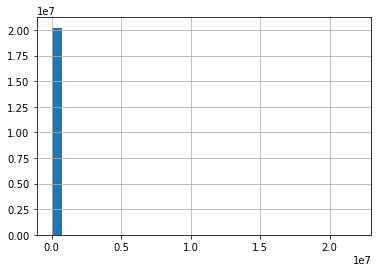

In [386]:
# посмотрим на распределение переменной
train_orig.value.hist(bins=30)

Очень некрасиво. Подозревая выбросы посмотрим на ящик с усами

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='value'>

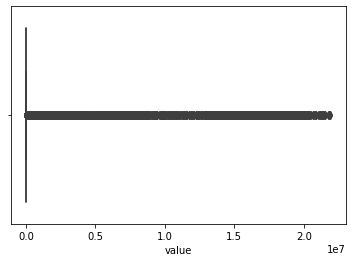

In [387]:
sns.boxplot(train_orig.value)

"Красота". Хорошо. Просто найдём интеркватильный размах и отсечем всё, что вне диапазона +- полтора интерквартильных размаха


\$IQR = Q_3 - Q_1$

\$[Q_1 - 1.5 * IQR, Q_3 + 1.5 * IQR]$

In [388]:
q1 = train_orig.value.quantile(0.25)
q3 = train_orig.value.quantile(0.75)

In [389]:
iqr = q3 - q1

In [390]:
# посмотрим сколько у нас значений вылетело за интервал "верных" значений
train_orig.query('(value < @q1 - 1.5 * @iqr) | (value > @q3 + 1.5 * @iqr)')

,obj_id,counter,datetime,value
242,192,0,2016-01-01 00:00:00,687.440
280,209,0,2016-01-01 00:00:00,893.280
281,209,1,2016-01-01 00:00:00,812.392
287,212,0,2016-01-01 00:00:00,851.280
315,223,0,2016-01-01 00:00:00,2027.520
...,...,...,...,...
20216071,1427,2,2016-12-31 23:00:00,3006.820
20216079,1433,2,2016-12-31 23:00:00,3173.880
20216084,1436,2,2016-12-31 23:00:00,1274.660
20216086,1437,2,2016-12-31 23:00:00,1518.920


Внушительно. Сделаем этим выбросам торжественное харакири в виде функции

In [391]:
# Функция для удаления шума в train
def remove_noise_train(dataset):
    return dataset.query('(value >= @q1 - 1.5 * @iqr) & (value <= @q3 + 1.5 * @iqr)')

In [392]:
# train_orig = prepare_train_test(remove_noise_train(train_orig))

In [393]:
train_orig = remove_noise_train(train_orig)

In [394]:
train_orig.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17742445 entries, 0 to 20216099
Data columns (total 4 columns):
 #   Column    Dtype         
---  ------    -----         
 0   obj_id    uint16        
 1   counter   uint8         
 2   datetime  datetime64[ns]
 3   value     float64       
dtypes: datetime64[ns](1), float64(1), uint16(1), uint8(1)
memory usage: 456.9 MB


In [395]:
# процент оптимизации
print('train сжат на {}%'.format(round((1 - 456.9/2048) * 100), 2))

train сжат на 78%


In [396]:
# странно, что процент сжатия снизился, но уже нет времени выяснять!

Проведем анализ weather_train на предмет выбросов

In [397]:
weather_train_orig.describe()

,city,temp,clouds,dew,precipitation,pressure,wdirection,wspeed
count,139773.000000,139773.000000,139773.000000,139773.000000,139773.000000,139773.000000,139773.000000,139773.000000
mean,7.478977,14.535796,1.085625,7.350926,0.629356,1016.270455,180.951457,3.559526
std,4.604744,10.864016,2.137058,9.786314,6.788452,8.072299,109.011972,2.333431
min,0.000000,-28.900000,0.000000,-35.000000,-1.000000,968.200000,0.000000,0.000000
25%,3.000000,7.200000,0.000000,0.600000,0.000000,1012.200000,90.000000,2.100000
50%,7.000000,15.000000,0.000000,8.300000,0.000000,1016.400000,190.000000,3.100000
75%,11.000000,22.200000,2.000000,14.400000,0.000000,1020.400000,270.000000,5.000000
max,15.000000,69.952944,9.000000,26.100000,343.000000,1198.080920,360.000000,19.000000


Что-то не то с temp, wspeed, dew?

<AxesSubplot:>

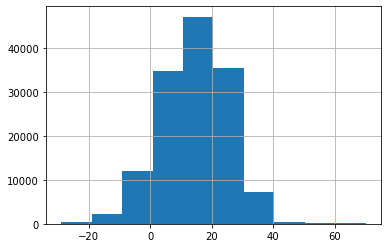

In [398]:
# распределение температур
weather_train_orig.temp.hist()

<AxesSubplot:>

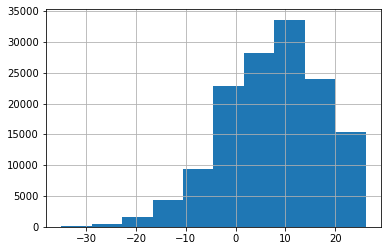

In [399]:
# распределение dew
weather_train_orig.dew.hist()

<AxesSubplot:>

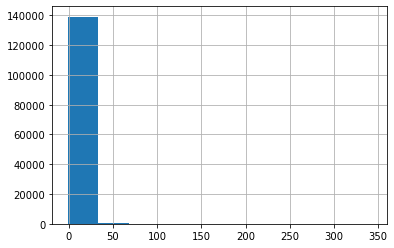

In [400]:
# распределение precipitation
weather_train_orig.precipitation.hist()

Всюду есть подозрительные хвосты. Применим проверку на вхождение интервала, но сразу для всех количественных признаков по порядку и выдадим результат. Всё завернём в функцию

In [401]:
# удаление выбросов в тренировочном датасете погоды
def remove_noise_weather(dataset):
    # количественные столбцы
    weather_num_vars = ['temp', 'dew', 'pressure', 'wdirection', 'wspeed', 'precipitation']

    for col in weather_num_vars:
        q1 = dataset[col].quantile(0.25)
        q3 = dataset[col].quantile(0.75)

        iqr = q3 - q1

        dataset = dataset[(dataset[col] >= q1 - 1.5 * iqr) & (dataset[col] <= q3 + 1.5 * iqr)]

    return dataset

In [402]:
weather_train_orig = remove_noise_weather(weather_train_orig)

<AxesSubplot:>

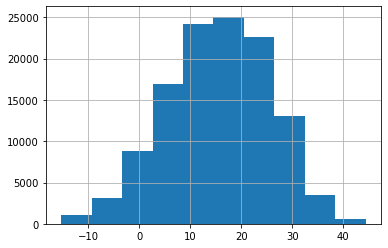

In [403]:
# распределение температур
weather_train_orig.temp.hist()

<AxesSubplot:>

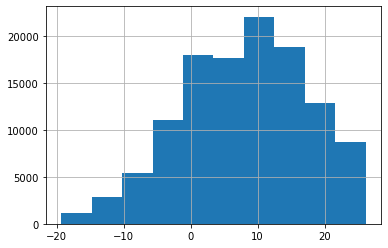

In [404]:
# распределение dew
weather_train_orig.dew.hist()

<AxesSubplot:>

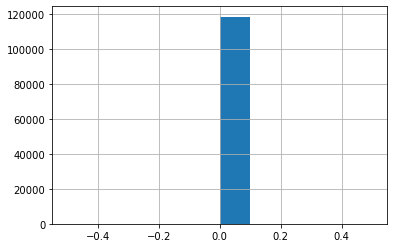

In [405]:
# распределение precipitation
weather.precipitation.hist()

По погоде уже уже красивей распределения без выбросов

In [406]:
weather_train_orig.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118686 entries, 0 to 139771
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   city           118686 non-null  uint8         
 1   datetime       118686 non-null  datetime64[ns]
 2   temp           118686 non-null  float64       
 3   clouds         118686 non-null  uint8         
 4   dew            118686 non-null  float64       
 5   precipitation  118686 non-null  float64       
 6   pressure       118686 non-null  float64       
 7   wdirection     118686 non-null  float64       
 8   wspeed         118686 non-null  float64       
dtypes: datetime64[ns](1), float64(6), uint8(2)
memory usage: 7.5 MB


**Вывод по weather_train_orig**

Удалось ещё немного пожать датасет

In [407]:
# процент оптимизации
print('weather_train_orig сжат на {}%'.format(round((1 - 7.5/20.8) * 100), 2))

weather_train_orig сжат на 64%


## Объединение в единые датасеты
Благодаря мета-информации из **building_meta** мы можем в train добавить информацию по зданию и по погоде. И то же самое про test

In [408]:
# проверим размеры train
train_orig.shape[0]

17742445

In [409]:
# сцепляем train_orig и building_meta, добавив доп.инфо по объектам
building_info_train = pd.merge(train_orig, building_meta_orig, how='inner', on='obj_id')

In [410]:
# размер получившейся таблицы
building_info_train.shape[0]

17742445

In [411]:
# появились NaNы?
building_info_train.isna().any()

obj_id      False
counter     False
datetime    False
value       False
city        False
function    False
square      False
year        False
dtype: bool

In [412]:
building_info_train.sample(4)

,obj_id,counter,datetime,value,city,function,square,year
2289860,205,1,2016-01-03 13:00:00,87.1124,2,1,60086,2001
5661374,516,0,2016-07-07 01:00:00,22.9800,3,7,9000,0
82731,9,0,2016-11-02 01:00:00,63.4781,0,2,27000,2010
15354237,1294,2,2016-04-23 00:00:00,113.8890,14,2,15649,0


In [413]:
building_info_train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17742445 entries, 0 to 17742444
Data columns (total 8 columns):
 #   Column    Dtype         
---  ------    -----         
 0   obj_id    uint16        
 1   counter   uint8         
 2   datetime  datetime64[ns]
 3   value     float64       
 4   city      uint8         
 5   function  uint8         
 6   square    int64         
 7   year      uint16        
dtypes: datetime64[ns](1), float64(1), int64(1), uint16(2), uint8(3)
memory usage: 659.9 MB


In [422]:
building_info_train.square = building_info_train.square.astype(np.float32)

Сцепка вроде успешна. Добавим информацию по погоде

In [423]:
out_train = pd.merge(building_info_train, weather_train_orig, how='outer', on=['city', 'datetime'])

MemoryError: Unable to allocate 135. MiB for an array with shape (17742539,) and data type int64

In [419]:
out_train.shape[0]

15120152

In [ ]:
# значений больше. Не совпали погоды или города из-за удаления выбросов или что там. Есть Nan?

In [292]:
out_train.isna().any()

obj_id           False
counter          False
datetime         False
value            False
city             False
function         False
square           False
year             False
temp             False
clouds           False
dew              False
precipitation    False
pressure         False
wdirection       False
wspeed           False
dtype: bool

In [293]:
out_train.dropna()

,obj_id,counter,datetime,value,city,function,square,year,temp,clouds,dew,precipitation,pressure,wdirection,wspeed
0,0,0,2016-01-01 00:00:00,0.0000,0,0,7432,2008,25.0,6,20.0,0.0,1019.7,0.0,0.0
1,1,0,2016-01-01 00:00:00,0.0000,0,0,2720,2004,25.0,6,20.0,0.0,1019.7,0.0,0.0
2,2,0,2016-01-01 00:00:00,0.0000,0,0,5376,1991,25.0,6,20.0,0.0,1019.7,0.0,0.0
3,3,0,2016-01-01 00:00:00,0.0000,0,0,23685,2002,25.0,6,20.0,0.0,1019.7,0.0,0.0
4,4,0,2016-01-01 00:00:00,0.0000,0,0,116607,1975,25.0,6,20.0,0.0,1019.7,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15120147,1400,1,2016-03-24 12:00:00,15.3753,15,1,21168,1928,1.7,0,1.7,0.0,1016.8,0.0,0.0
15120148,1400,1,2016-03-24 13:00:00,25.0848,15,1,21168,1928,2.8,0,2.2,0.0,1016.6,320.0,1.5
15120149,1400,1,2016-03-24 14:00:00,32.3439,15,1,21168,1928,5.6,0,4.4,0.0,1015.2,110.0,2.1
15120150,1400,1,2016-03-24 15:00:00,24.2214,15,1,21168,1928,11.1,0,4.4,0.0,1013.9,150.0,5.1


In [ ]:
# сцепляем test_orig и building_meta, добавив доп.инфо по объектам
building_info_test = pd.merge(test_orig, building_meta_orig, how='outer', on='obj_id')

In [425]:
building_info_train.to_csv('building_info_train.csv')

In [ ]:
building_info_test.to_csv('building_info_train.csv')

In [426]:
train_orig.to_csv('train_orig.csv')

In [427]:
weather_train_orig.to_csv('weather_train_orig.csv')

In [428]:
weather_test_orig.to_csv('weather_test_orig.csv')

In [ ]:
test_orig.to_csv('test_orig.csv')

In [ ]:
building_meta_orig.to_csv('building_meta_orig.csv')

# Потерпел фейл при сцепке из-за потёкшей ОЗУ. В следующем модуле загружу уже то, что успел сделать